## Jupyter notebook to perform the analysis and produce the figures in the paper

## "The Emperor's New Arc: gigaparsec patterns abound in a $\Lambda$CDM universe".
## written by Till Sawala and Meri Teeriaho.

### This notebook includes all functions that were used to compute based on the raw simulation outputs. Results of these computations can be found in the `results.zip` archive, and should be unpacked into a folder `results` (as defined below). Access to the raw data will be facilitated on reasonable request by email.

### You are free to use any part of this notebook with attribution (CC BY, https://creativecommons.org/licenses/by/4.0/). If you use any part of it for scientific work, we ask that you cite the corresponding paper (you should also cite the papers for the python packages such as scipy, where available). Please contact till.sawala@helsinki.fi or meri.teeriaho@helsinki.fi with any questions or feedback.


### Define the system type. The `'local'` type assumes that all the required modules are installed, and that the raw data is in the "data" directory, and that the results are in the `'results'` directory. The `'Puhti'` system type is specific to the Puhti computer at CSC and will attempt to install the packages, etc. The  `'N_jobs'` variable is used for parallelisation. 

In [ ]:
import sys
system = 'local'

if system == 'Puhti':
    sys.path.append('/users/sawalati/.local/lib/python3.10/site-packages')
    !{sys.executable} -m pip install --user -r requirements_arc.txt
    N_jobs = 10
    datapath = "/projappl/pjohanss/till/meri/data"
    resultspath = "results"
    plots_dir = "figures"

    raw_data = False

if system == 'local':
    N_jobs = 6
    datapath = "data"
    resultspath = "results"
    plots_dir = "figures"

    raw_data = False
    

## Imports

In [2]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as cm
import matplotlib.offsetbox as offsetbox
import time
import itertools
from tqdm import tqdm
import h5py
import os
import math
from scipy.spatial import ConvexHull, Delaunay
from scipy.signal import savgol_filter
from scipy.stats import lognorm
from scipy.stats import percentileofscore
from sphviewer.tools import QuickView
from mst_clustering import MSTClustering
from joblib import Parallel, delayed
from sklearn import cluster #, datasets, mixture
from sklearn.metrics import pairwise_distances

print ("Imports completed")

Imports completed


### Read the **Flamingo-10K** subhalo catalogue data

In [3]:
if raw_data :
    
    redshift = 0.7
    
    filename = datapath+"/reduced_flamingo_HBT_snap100_threshold_5e11_.hdf5"
    
    with h5py.File(filename, "r") as f:
         sm_read = f['sm'][()]  # subhalo masses
         x_read = f['x'][()]  # x
         y_read = f['y'][()]  # y
         z_read = f['z'][()]  # z
    

    
    print ("read")
    
    full_data_flamingo = np.vstack((x_read, y_read, z_read))
    
    # create subsets for subhaloes of different masses
    
    mask_0 = (sm_read < 10**12)
    mask_1 = ((sm_read > 10**12) & (sm_read < 10**12.5))
    mask_2 = ((sm_read > 10**12.5) & (sm_read < 10**13))
    mask_3 = ((sm_read > 10**13) & (sm_read < 10**13.5))
    mask_4 = ((sm_read > 10**13.5) & (sm_read < 10**14))
    mask_5 = (sm_read > 10**14) 
    
    flamingo_data_0 = full_data_flamingo[:,mask_0]
    shuffled_indices = np.random.permutation(flamingo_data_0.shape[1])
    flamingo_data_0 = flamingo_data_0[:, shuffled_indices]
    
    flamingo_data_1 = full_data_flamingo[:,mask_1]
    shuffled_indices = np.random.permutation(flamingo_data_1.shape[1])
    flamingo_data_1 = flamingo_data_1[:, shuffled_indices]
    
    flamingo_data_2 = full_data_flamingo[:,mask_2]
    shuffled_indices = np.random.permutation(flamingo_data_2.shape[1])
    flamingo_data_2 = flamingo_data_2[:, shuffled_indices]
    
    flamingo_data_3 = full_data_flamingo[:,mask_3]
    shuffled_indices = np.random.permutation(flamingo_data_3.shape[1])
    flamingo_data_3 = flamingo_data_3[:, shuffled_indices]
    
    flamingo_data_4 = full_data_flamingo[:,mask_4]
    shuffled_indices = np.random.permutation(flamingo_data_4.shape[1])
    flamingo_data_4 = flamingo_data_4[:, shuffled_indices]
    
    flamingo_data_5 = full_data_flamingo[:,mask_5]
    shuffled_indices = np.random.permutation(flamingo_data_5.shape[1])
    flamingo_data_5 = flamingo_data_5[:, shuffled_indices]
    
    print ("Number of Subhalos in subsample 0:", flamingo_data_0.shape[1])
    print ("Number of Subhalos in subsample 1:", flamingo_data_1.shape[1])
    print ("Number of Subhalos in subsample 2:", flamingo_data_2.shape[1])
    print ("Number of Subhalos in subsample 3:", flamingo_data_3.shape[1])
    print ("Number of Subhalos in subsample 4:", flamingo_data_4.shape[1])
    print ("Number of Subhalos in subsample 5:", flamingo_data_5.shape[1])
    
    # select subhalos in the default mass range:
    mask = ((sm_read > 1.e12) & (sm_read < 5.e12))
    full_data_flamingo = full_data_flamingo[:,mask]
    
    # Shuffle the order of points.
    np.random.seed(0)
    num_points = full_data_flamingo.shape[1]
    
    print ("Number of Subhalos in default sample:", num_points)
    
    shuffled_indices = np.random.permutation(num_points)
    full_data_flamingo = full_data_flamingo[:, shuffled_indices]

### Read data at different redshifts

In [4]:
if raw_data:
    
    filenames = [datapath+"/reduced_flamingo_HBT_snap144_z0.0_N10000000.hdf5",
                 datapath+"/reduced_flamingo_HBT_snap107_z0.5_N10000000.hdf5",
                 datapath+"/reduced_flamingo_HBT_snap100_z0.7_N10000000.hdf5",
                 datapath+"/reduced_flamingo_HBT_snap90_z1.0_N10000000.hdf5",
                 datapath+"/reduced_flamingo_HBT_snap71_z2.0_N10000000.hdf5",
                 datapath+"/reduced_flamingo_HBT_snap59_z3.0_N10000000.hdf5"]
    
    flamingo_redshift_data = []
    
    for filename in filenames:
        
        with h5py.File(filename, "r") as f:
             print("Keys: %s" % f.keys())
             sm_read = f['sm'][()]  # stellar mass
             x_read = f['x'][()]  # x
             y_read = f['y'][()]  # y
             z_read = f['z'][()]  # z
    
        redshift_data = np.vstack((x_read, y_read, z_read))
    
        # Shuffle the order of points
        num_points = redshift_data.shape[1]
        shuffled_indices = np.random.permutation(num_points)
        redshift_data = redshift_data[:, shuffled_indices]
    
        flamingo_redshift_data.append(redshift_data)
    
    flamingo_redshift_data = np.array(flamingo_redshift_data)

print ("done reading")

done reading


## Read the particle data (to plot and compute the matter density)

In [5]:
if raw_data:
    
    fname = datapath+"/reduced_particledata_snap100.hdf5"
    print ("fname:", fname)
    f = h5py.File(fname, 'r')
    x_p = f.get('x')[:]
    y_p = f.get('y')[:]
    z_p = f.get('z')[:]
    
    particle_positions = np.vstack((x_p, y_p, z_p))  # revert later
    default_particle_density = len(x_p) / 2800**3.
    
    print ("default particle density:", default_particle_density)
    
    # create a subsample that will be used for plotting the background density:
    
    # Shuffle the order of points
    np.random.seed(0)
    num_points = 10000000
    print ("num_points", num_points)
    shuffled_indices = np.random.permutation(len(x_p))
    
    x_p_plot = x_p[shuffled_indices[0:num_points]]
    y_p_plot = y_p[shuffled_indices[0:num_points]]
    z_p_plot = z_p[shuffled_indices[0:num_points]]
    
    particle_positions_plot = particle_positions[:, shuffled_indices[0:num_points]]
    particle_positions_plot = np.array(particle_positions_plot.T)
    
    plot_particle_density = num_points / 2800**3.

## Set some global parameters.

In [6]:
DEFAULT_DENSITY = 504 / (1541*1615*338)

print ("default point density:", DEFAULT_DENSITY)

DEFAULT_SLICE_THICKNESS = 338. # thickness of the slice in Mp
DEFAULT_BOX_SIZE = 2800. # width of the slice

DEFAULT_N_PER_SLICE = int (np.round(DEFAULT_DENSITY * DEFAULT_SLICE_THICKNESS * DEFAULT_BOX_SIZE**2))

print ("default N:", DEFAULT_N_PER_SLICE)

DEFAULT_LINKING_LENGTH = 95.

colors = [plt.cm.inferno_r(0.1), plt.cm.inferno_r(0.25), plt.cm.inferno_r(0.4), plt.cm.inferno_r(0.55), plt.cm.inferno_r(0.7), plt.cm.inferno_r(0.85)]

color_flamingo = colors[2]

linking_lengths = range(70,150,1)
group_lengths = [600,800,1000]
max_bas = [0.3, 0.4, 0.5]

min_group_length = 5 # only consider groups with at least this many members.

scale_factors = np.logspace(-.7, 0., 41)
L_min_default = DEFAULT_LINKING_LENGTH * 6 # we look for these groups in the full box.
N_slices_default = 100
DEFAULT_MAX_BA = 0.5
DEFAULT_L_MIN = 600

redshifts = [0, 0.5, 0.7, 1, 2, 3]

# Make directory for plots
os.makedirs(plots_dir, exist_ok=True) 

default point density: 5.991542865916867e-07
default N: 1588


## Functions and classes

### Helper functions to compute properties of groups

In [7]:
def distances_3D(segments):

    '''
    Compute the lengths of the segments of the MST
    '''
    
    x_dis = segments[0]
    y_dis = segments[1]
    z_dis = segments[2]

    dis = []
    for i in range(len(x_dis[0])):
        p1 = [x_dis[0][i], y_dis[0][i], z_dis[0][i]]
        p2 = [x_dis[1][i], y_dis[1][i], z_dis[1][i]]
        dis.append(math.dist(p1, p2))
    return dis


def mean_dist(cluster, linklen, min_size):

    '''
    Compute the MST of a group, return the overdensity and the hull volume
    '''
    
    sub_alg = MSTClustering(cutoff_scale=linklen, min_cluster_size=min_size)
    sub_labels = sub_alg.fit_predict(cluster)
    segments = sub_alg.get_graph_segments(full_graph=True)
 
    dis_3D = distances_3D(segments)
    mean_dist = np.mean(dis_3D)

    return mean_dist
 
def create_sphere_points(center, radius, num_points=100):
    
    '''
    Expand a point into a sphere, used in computing the convex hull
    '''
    
    # Generate uniform random points on a sphere
    phi = np.random.uniform(0, 2 * np.pi, num_points)  # Azimuthal angle
    cos_theta = np.random.uniform(-1, 1, num_points)   # Cosine of polar angle
    theta = np.arccos(cos_theta)                        # Polar angle

    # Convert spherical coordinates to Cartesian coordinates
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)

    return np.vstack((x, y, z)).T


def hull_and_points(cluster_points, mean_dist):
    
    '''
    Return the convex hull object and the set of points that define it.
    '''
    
    radius = mean_dist / 2

    expanded_points = []
    for point in cluster_points:
        points = create_sphere_points(point, radius)    
        expanded_points.append(points)

    expanded_points = np.vstack(expanded_points)
    hull = ConvexHull(expanded_points)

    return hull, expanded_points


def eigen(data):

    '''
    Function to compute the eigenvectors and eigenvalues.
    Returns eigenvectors and eigenvalues in descending order of the eigenvalues.
    '''
    
    covariance = np.cov(data.T)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    idx_sorted = eigenvalues.argsort()[::-1]                      
    eigenvalues = eigenvalues[idx_sorted]
    eigenvectors = eigenvectors[:,idx_sorted]
    return np.sqrt(eigenvalues), eigenvectors


### Define the __Mygroup__ class that holds the basic properties of an identified cluster, as well as methods to calculate additional properties

In [8]:
class MyGroup:
    
    '''
    A class to contain all the information about a group. The overdensities are computed only after a call.
    '''
    
    def __init__(self, coords, background, linking_length):    # if a group is created from a set of points

        self.center = np.mean(coords, axis = 0)
        self.coords = coords 
        self.background = background
        self.linking_length = linking_length

        self.eigenvalues, self.eigenvectors =  eigen(coords)

        sqdistances = pairwise_distances(self.coords, metric='sqeuclidean', n_jobs=1, force_all_finite=True)
        self.extent = np.max(sqdistances)**.5
        
        self.ba = self.eigenvalues[1] / self.eigenvalues[0]

        self.M = len(self.coords)
        self.N = len(self.background)
    
    def point_overdensity(self):
    
        '''
        Method to compute the points overdensity, defined by the group members and the hull volume
        '''

        mean_distance = mean_dist(self.coords,self.linking_length, self.M)
        
        hull, expanded_points = hull_and_points(self.coords, mean_distance)
        hullvolume= hull.volume

        density = self.M / hullvolume
        overdensity  = (density - DEFAULT_DENSITY) / DEFAULT_DENSITY
        
        return overdensity

    def particle_overdensity(self, pos):

        '''
        Method to compute the particle overdensity, defined by the hull volume and the number of particles
        inside the hull volume. 
        '''
        
        mean_distance = mean_dist(self.coords, self.linking_length, self.M)

        hull, expanded_points = hull_and_points(self.coords, mean_distance)
        hullvolume= hull.volume

        hull_delaunay = Delaunay(expanded_points[hull.vertices])

        # First mask the positions to a box around the hull.

        if len(pos) == 3 and len(pos.T) > 3 :
            print ("transposing")
            pos = pos.T

        x_lims = [min(expanded_points[:,0]), max(expanded_points[:,0])]
        y_lims = [min(expanded_points[:,1]), max(expanded_points[:,1])]
        z_lims = [min(expanded_points[:,2]), max(expanded_points[:,2])]
        
        mask = ((pos[:,0] > x_lims[0]) & (pos[:,0] < x_lims[1]) &
                (pos[:,1] > y_lims[0]) & (pos[:,1] < y_lims[1]) & 
                (pos[:,2] > z_lims[0]) & (pos[:,2] < z_lims[1]))

        pos = pos[mask,:]
        
        inside = hull_delaunay.find_simplex(pos) >= 0
        particle_positions_inside = pos[inside]
        
        density = len(particle_positions_inside) / hullvolume

        overdensity  = (density - default_particle_density) / default_particle_density
        
        return overdensity

### Functions for computing 

In [9]:
def find_groups(data, M, linking_length):

    '''
    Function to find and return the groups in the data above some threshold count.
    This will be called in parallel. This function is agnostic to the orientation of the slice.
    '''

    Groups = [] # list of groups to be returned.
    
    single_linkage = cluster.AgglomerativeClustering(
            n_clusters=None,
            linkage="single",
            metric="euclidean",
            distance_threshold=linking_length)

    single_linkage.fit(data)
    y_pred = single_linkage.labels_.astype(int)
    values, counts = np.unique(y_pred, return_counts=True)
        
    idx = np.where(counts > M)[0]

    N_groups = len(idx)
        
    for i in range (N_groups):

        members = np.where(y_pred == values[idx[i]])[0]
        group_coords = data[members,:]

        if (np.min(group_coords) > linking_length) and (np.max(group_coords) < DEFAULT_BOX_SIZE - linking_length) :

        # we have found a valid group, now let's create a group class instance.
                
            ThisGroup = MyGroup(coords=group_coords, background=data, linking_length = linking_length)
            Groups.append(ThisGroup)

    return Groups


def find_UniqueSetsOfGroups(Groups):

    '''
    Function to break the list of groups into disjoints subsets.
    Groups within one subset overlap. 
    '''

    overlaps = []
    
    for i, ThisGroup in enumerate( Groups ):

        # for each group, check if its members are also part of other groups. In that case, only plot the "most prominent" group.
        overlaps_i = []
        this_set = set(ThisGroup.coords[:,0]) # we use this coordinate, which should be unique to each subhalo.
        
        for j, OtherGroup in enumerate (Groups):
            other_set = set (OtherGroup.coords[:,0])
            intersection = this_set.intersection(other_set)

            if len(intersection) > 0:
                overlaps_i.append(j)
        overlaps.append(overlaps_i)

    UniqueSetsOfGroups = [list(x) for x in set(tuple(x) for x in overlaps)]

    return UniqueSetsOfGroups

## Computing Functions

In [10]:
def find_groups_in_slices(full_data=[], depth='z', N_slices=400, M_min=10, L_min=730, max_ba=0.35, offset_0=0, offset_1=0, offset_2=0, 
                          slice_thickness=DEFAULT_SLICE_THICKNESS, box_size=DEFAULT_BOX_SIZE, min_point_overdensity=0.7, linking_length=DEFAULT_LINKING_LENGTH,
                          slices_to_process=None, edge_limit=0,  N_per_slice=DEFAULT_N_PER_SLICE,  N_jobs=1):
    '''
    Finds unique groups in specified slices and returns them.

    Parameters:
    - slices_to_process: List of slice indices to process. If None, processes all slices.
    '''
    verbatim = False # Print extra information?

    if verbatim:
        print("linking_length:", linking_length)
        print("L_min:", L_min)
        print("box:", box_size)
        print("thickness:", slice_thickness)
        print("N_per_slice:", N_per_slice)
        print("len full data:", len(full_data))
    
    single_linkage = cluster.AgglomerativeClustering(
        n_clusters=None,
        linkage="single",
        metric="euclidean",
        distance_threshold=linking_length)
    
    slice_minima = np.linspace(edge_limit, DEFAULT_BOX_SIZE - slice_thickness-edge_limit, N_slices)
    slice_maxima = slice_minima + slice_thickness

    Groups = [] # List that will hold the groups found.

    # Default to all slices if none are specified
    if slices_to_process is None:
        slices_to_process = range(N_slices)

    slices_data = []
    
    for i_slice in slices_to_process: # Loop over the specified slices.
        match depth:
            case 'x':
                mask = (
                    (full_data[0, :] > slice_minima[i_slice]) & 
                    (full_data[0, :] < slice_maxima[i_slice]) & 
                    ((full_data[1, :] > offset_1) & (full_data[1, :] < box_size + offset_1) if box_size < DEFAULT_BOX_SIZE else True) &
                    ((full_data[2, :] > offset_2) & (full_data[2, :] < box_size + offset_2) if box_size < DEFAULT_BOX_SIZE else True)
                )
            case 'y':
                mask = (
                    (full_data[1, :] > slice_minima[i_slice]) & 
                    (full_data[1, :] < slice_maxima[i_slice]) & 
                    ((full_data[2, :] > offset_1) & (full_data[2, :] < box_size + offset_2) if box_size < DEFAULT_BOX_SIZE else True) &
                    ((full_data[0, :] > offset_2) & (full_data[0, :] < box_size + offset_0) if box_size < DEFAULT_BOX_SIZE else True)
                )
            case 'z':
                mask = (
                    (full_data[2, :] > slice_minima[i_slice]) & 
                    (full_data[2, :] < slice_maxima[i_slice]) & 
                    ((full_data[0, :] > offset_0) & (full_data[0, :] < box_size + offset_0) if box_size < DEFAULT_BOX_SIZE else True) &
                    ((full_data[1, :] > offset_1) & (full_data[1, :] < box_size + offset_1) if box_size < DEFAULT_BOX_SIZE else True)
                )

        if np.count_nonzero(mask) < N_per_slice:
            print(f"Warning: Only {np.count_nonzero(mask)} points in slice {i_slice}, expected {N_per_slice}. Depth: {depth}")
        
        slices_data.append(np.vstack((
            full_data[0, mask][:N_per_slice], 
            full_data[1, mask][:N_per_slice], 
            full_data[2, mask][:N_per_slice]
        )).T)

    TheseGroups = Parallel(n_jobs=N_jobs)(
        delayed(find_groups)(slices_data[i], M_min, linking_length) for i in range(len(slices_data))
    )
    TheseGroups = list(itertools.chain(*TheseGroups))
    
    for ThisGroup in TheseGroups:
        if min_point_overdensity > 0:
            if ThisGroup.extent > L_min and ThisGroup.ba < max_ba and ThisGroup.point_overdensity() > min_point_overdensity:
                Groups.append(ThisGroup)
        else:
            if ThisGroup.extent > L_min and ThisGroup.ba < max_ba: 
                Groups.append(ThisGroup)
                
    UniqueSetsOfGroups = find_UniqueSetsOfGroups(Groups)
    
    return Groups, UniqueSetsOfGroups


def find_groups_in_box(data = [], depth='z', M_min = 10, L_min = 700, max_ba = 0.35, box_size=DEFAULT_BOX_SIZE, min_point_overdensity = 0.7, linking_length = DEFAULT_LINKING_LENGTH):

    '''
    Finds all the unique groups in this box and return them. 
    '''
    
    verbatim = False # Print extra information?

    print ("linking_length", linking_length)
    print ("box:", box_size)
    
    single_linkage = cluster.AgglomerativeClustering(
        n_clusters=None,
        linkage="single",
        metric="euclidean",
        distance_threshold=linking_length)
        
    Groups = [] # List that will hold the groups found.

    TheseGroups = find_groups(data, M_min, linking_length)

    for i, ThisGroup in enumerate (TheseGroups):

    # if the group also matches the selection criteria, we add it to the Groups list.
    # However, if min_point_overdensity < 0, we don't even compute the overdensity, which takes time.
        
        if min_point_overdensity > 0:
            if ThisGroup.extent > L_min and ThisGroup.ba < max_ba and ThisGroup.point_overdensity() > min_point_overdensity:
                Groups.append(ThisGroup)
        else:
            if ThisGroup.extent > L_min and ThisGroup.ba < max_ba: 
                Groups.append(ThisGroup)
                
    UniqueSetsOfGroups = find_UniqueSetsOfGroups(Groups)    

    return Groups, UniqueSetsOfGroups

## Plotting Functions

### Plot a single group and overplot the projected mass density in the same slice. *(Figure 1)*

In [11]:
def plot_group_sph_rotated(ThisGroup, depth, filename, label, background):

    '''
    Function to plot a given group on top of an image of the particle density.
    This version rotates the structure so it is aligned with the x-axis
    '''
  
    # we still have to ensure that the depth dimension is the z-dimension.

    match depth:
        case 'z':
            axes = [0,1,2]
            axlabels = [r'$x~\mathrm{[Mpc]}$', r'$y~\mathrm{[Mpc]}$']
        case 'x':
            axes = [1,2,0]
            axlabels = [r'$y~\mathrm{[Mpc]}$', r'$z~\mathrm{[Mpc]}$']
        case 'y':
            axes = [2,0,1]
            axlabels = [r'$z~\mathrm{[Mpc]}$', r'$x~\mathrm{[Mpc]}$']

    # find the longest dimension of the structure.

    coords = ThisGroup.coords

    x_size = np.max(coords[:,axes[0]]) - np.min(coords[:,axes[0]])
    y_size = np.max(coords[:,axes[1]]) - np.min(coords[:,axes[1]])

    sizes = np.array([x_size, y_size])

    
    sorted_sizes = np.argsort(sizes) 
    print ("sizes:", sizes)
    first = sorted_sizes[1]
    second = sorted_sizes[0]

    axes = [axes[first], axes[second], axes[2]]
    
    pos = particle_positions_plot[:,axes]

    print ("len pos", len(pos))
    print ("axes:", axes)
 
    x_center = ThisGroup.center[axes[0]]  # will draw a 1.6 Gpc x 1.6 Gpc box, centered on the group but not over the edge of the box.
    y_center = ThisGroup.center[axes[1]]
    z_center = ThisGroup.center[axes[2]]

    x_lims = [x_center - 800, x_center + 800]
    y_lims = [y_center - 800, y_center + 800]

    # Make sure the plot actually fits
    if x_lims[0] < 50 :
        x_lims = [50,1650]
    if x_lims[1] > 2750 :
        x_lims = [1150, 2750]
        
    if y_lims[0] < 50 :
        y_lims = [50,1650]
    if y_lims[1] > 2750 :
        y_lims = [1150, 2750]

    # For the depth, we use +/- 338/2 Mpc around the midpoint of the limits of the background.
    
    z_center = 0.5 * ( np.min(ThisGroup.background[:,axes[2]]) + np.max(ThisGroup.background[:,axes[2]]) )    
    z_lims = [z_center - DEFAULT_SLICE_THICKNESS / 2, z_center + DEFAULT_SLICE_THICKNESS / 2]

    if background == True:

        # the slice of the particles
        mask = ((pos[:,0] > x_lims[0] - 50 ) & (pos[:,0] < x_lims[1] +50 ) &
                (pos[:,1] > y_lims[0] - 50 ) & (pos[:,1] < y_lims[1] +50) & 
                (pos[:,2] > z_lims[0] - 50 ) & (pos[:,2] < z_lims[1] +50) )

        print ("limits:", x_lims, y_lims, z_lims)
        print ("masked")
        
        pos = pos[mask,:]

        print ("len:", len(pos))
        
        qv = QuickView(pos, r="infinity", x=0, y=0, z=0, extent = [x_lims[0],x_lims[1]+50, y_lims[0], y_lims[1]+50],
                       xsize=64, ysize=64, plot=False, logscale=True)

        print ("qv computed")


        img = qv.get_image()
        image_extent = qv.get_extent()
        print ("min / max / mean:", img[1:-2,1:-2].min(), " ", img[1:-2,1:-2].max(), img[1:-2,1:-2].mean() )
        print ("extent:", image_extent)

        min_dens =  img[1:-2,1:-2].min()
        max_dens =  img[1:-2,1:-2].max()

    
    # start the plot
    fig = plt.figure(figsize=(4,4))
    gs = GridSpec(1, 1, hspace=0.05,wspace=0.5, bottom=0.15, left=0.15, right=0.7) 
    ax = fig.add_subplot(gs[0])
    ax.set_aspect(1)

    if background == True:
        
        my_cmap = matplotlib.colormaps['coolwarm']
        im = ax.imshow(img, extent=qv.get_extent(),  cmap=my_cmap, origin='lower', vmin =  0.05, vmax = 0.15, alpha=.6 )

    # plot the halos and the background

    ax.scatter(ThisGroup.background[:,axes[0]] , ThisGroup.background[:,axes[1]] , s=2, color='white', alpha=1., edgecolor = 'black', lw=.5)
    ax.scatter(ThisGroup.coords[:,axes[0]], ThisGroup.coords[:,axes[1]], s=14, color='white', alpha=1., edgecolor = 'black', lw=1.5)

    count_in_corners_0 = len( np.where ( (ThisGroup.coords[:,axes[0]] < x_lims[0] + 800) & (ThisGroup.coords[:,axes[1]] > y_lims[1] - 800) )[0]) # top left
    count_in_corners_1 = len( np.where ( (ThisGroup.coords[:,axes[0]] > x_lims[1] - 800) & (ThisGroup.coords[:,axes[1]] > y_lims[1] - 800) )[0]) # top right
    count_in_corners_2 = len( np.where ( (ThisGroup.coords[:,axes[0]] < x_lims[0] + 800) & (ThisGroup.coords[:,axes[1]] < y_lims[0] + 800) )[0]) # bottom left
    count_in_corners_3 = len( np.where ( (ThisGroup.coords[:,axes[0]] > x_lims[1] - 800) & (ThisGroup.coords[:,axes[1]] < y_lims[0] + 800) )[0]) # bottom right

    print ("corner counts:", count_in_corners_0, count_in_corners_1, count_in_corners_2, count_in_corners_3)

    emptiest_corner = np.argmin([count_in_corners_0, count_in_corners_1, count_in_corners_2, count_in_corners_3])

    match emptiest_corner:
        case 0:
            locstr = 'upper left'
        case 1:
            locstr = 'upper right'
        case 2:
            locstr = 'lower left'
        case 3:
            locstr = 'lower right'
    
    textstr = '\n'.join((
    r'$\mathrm{N}=%d$' % (ThisGroup.M),
    r'$\mathrm{L}=%.0f~\mathrm{Mpc}$' % (ThisGroup.extent),
    r'$\mathrm{b / a}=%.2f$' % (ThisGroup.ba),
    r'$\mathrm{\delta_p} =%.2f$' % (ThisGroup.point_overdensity()),
    r'$\mathrm{\delta_m} =%.3f$' % (ThisGroup.particle_overdensity(particle_positions.T))

    ) )

    ob = offsetbox.AnchoredText(textstr, loc=locstr,
                    prop=dict(color='black', size=9))
    ob.patch.set(boxstyle='round, pad=0.1', facecolor='white', edgecolor='none', alpha=0.7)
    ax.add_artist(ob)

    
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)
   
    ax.set_xticks(np.linspace(x_lims[0], x_lims[1],5))
    #ax.set_xticklabels(['0','400','800','1200','16000'])

    ax.set_yticks(np.linspace(y_lims[0], y_lims[1],5))
    #ax.set_yticklabels(['0','400','800','1200','16000'])

    ax.set_aspect(1)
    plt.gca().set_aspect('equal')
    filename = 'sph_rotated_'+filename
    
    if background == False:
        appendix = '_no_bg'
    else:
        appendix = ''

    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cbar =fig.colorbar(im, cax=cax, cmap=my_cmap)
    cbar.set_ticks(ticks=[0.05, 0.1, 0.15], labels = ['-0.5', '0', '+0.5'])
    cbar.ax.set_ylabel(r'$\mathrm{\delta (25 Mpc)}$', labelpad=-5)
    
    plt.savefig(plots_dir+'/'+filename+appendix+'.pdf', dpi=200)

### Find and plot prominent groups in x,y,z slices of Flamingo and plot them *(Figure 1)*

In [12]:
def plot_slices(background):
    
    data_flamingo = full_data_flamingo[:, 0:15000]
    
    for depth in ['x', 'y', 'z']:
    
        print ("depth:", depth)
        
        parameters = {'full_data':data_flamingo, 'depth':depth, 'N_slices':1000, 'M_min':20, 'L_min':730, 'max_ba':0.4, 'min_point_overdensity':0.4, 'linking_length':DEFAULT_LINKING_LENGTH}
        Groups, UniqueSetsOfGroups = find_groups_in_slices(**parameters)
    
        print ("done finding groups, now plotting")
    
        # For each set of groups that meet the minimum criteria, plot the one that has the best "score" based on the length,
        # overdensity, and anisotropy.
        
        for i, ThisSetOfGroups in enumerate (UniqueSetsOfGroups):
            print ("i:", i)
            
            extents = [Groups[j].extent for j in ThisSetOfGroups]
            densities = [Groups[j].point_overdensity() for j in ThisSetOfGroups]

            bas = [Groups[j].ba for j in ThisSetOfGroups]

            scores = np.array(extents) - (np.array(bas)* 15)**3 + (np.array(densities) * 100)

            ThisGroup = Groups[ThisSetOfGroups[np.argmax(scores)]]
            particle_overdensity = ThisGroup.particle_overdensity(particle_positions.T)

            print ("particle_overdensity", particle_overdensity)
            print ("point overdensity:", ThisGroup.point_overdensity())
            print ("extent:",  ThisGroup.extent)
            print ("b/a:", ThisGroup.ba)

            filename = "arc_"+depth+"_"+str(i)
            plot_group_sph_rotated(ThisGroup, depth, filename+"_most_prominent_", str(i), background = background)
    print ("done")

### Plot the "Giant Arc" as in Lopez et al. 2022 *(Figure 1)*

In [13]:
def plot_GA():
    
    # data digitised from the plot
    xy_data_lopez=[(-529.362736380512, 170.110375362404), (-398.055093735679, 170.110375362404), (-457.143532925854, 128.644371302392), (-476.839679322578, 101.000368595718), (-455.830456499405, 102.256914173294), (-445.325845087819, 80.8956393544996), (-479.465832175475, 79.6390937769235), (-467.648144337440, 58.2778189581294), (-512.292742836683, 41.9427264496398), (-505.111329902421, 11.6664218310366), (-414.307055059761, 39.4386018588655), (-371.793565206712, 44.4558176047920), (-345.532036677746, 15.5552693205412), (-291.695903193364, 13.0421781653889), (-252.303610399915, -4.54945992067678), (-205.631742383332, -6.40509568353129), (-188.388403622302, 3.90801358528007), (-198.467476915533, 60.7909101132816), (-147.257496284048, 80.8956393544996), (-145.944419857600, 36.9165441393353), (-136.752884872462, 9.27254143266057), (-94.7344392261153, 35.6599985617592), (-113.117509196392, 23.0945427859979), (-82.9167513880803, 4.24635912235608), (-131.500579166668, -17.1149156964380), (-145.944419857600, -39.7327360928082), (-107.865203490599, -56.0678286012978), (-75.0382928293904, -27.1672803170470), (-52.7159935797688, -20.8845524291664), (-86.8559806674253, -100.046923816462), (-29.0806179036989, 53.2516366478249), (66.7739612270290, 58.2778189581294), (28.6947448600275, 20.5814516308457), (31.3208977129241, -2.03636876552454), (19.5032098748892, -27.1672803170470), (41.8255091245108, -18.3714612740141), (111.418559726272, 26.8641795187263), (107.334856129362, 10.9209278880718), (92.2469347134606, 22.8841346398930), (160.000000000000, 60.0000000000000), (152.167536908040, 31.5471464256945), (215.967890323851, 36.0849145039715), (272.439824766224, 49.2856943680500), (328.480675739571, 83.5252171405038), (318.565755951979, 75.2747297254547), (306.495418819258, 71.1494860179301), (287.527746182125, 72.7995835009399), (286.234495775048, 107.864155014899), (284.510161898945, 89.7130827017906), (267.697906606940, 89.3005583310381), (227.176060518520, 113.226971834680), (351.328099597936, 123.540081103492), (313.392754323670, 187.068834199370), (263.818155385709, 193.669224131409), (247.005900093704, 198.619516580439)]
    xy_data_lopez = np.array(xy_data_lopez) + [800,800]
    
    indexes = list(range(len(xy_data_lopez)))
    
    del indexes[0:10]
    del indexes[1]
    
    xy_arc_lopez = xy_data_lopez[indexes,:]
    
    print ("len arc:", len(xy_arc_lopez)) 
    
    # Compute the projected size of the GA
    
    GA_distances = pairwise_distances(xy_arc_lopez, metric='euclidean', n_jobs=2, force_all_finite=True)
    print ("max xy:", np.max(GA_distances))
    max_xyz = (np.max(GA_distances)**2 + DEFAULT_SLICE_THICKNESS**2)**.5 
    
    print ("max xyz:", (np.max(GA_distances)**2 + DEFAULT_SLICE_THICKNESS**2)**.5 )
    
    # start the plot

    fig = plt.figure(figsize=(4,4))
    gs = GridSpec(1, 1, hspace=0.05,wspace=0.5, bottom=0.15, left=0.15, right=0.7) 
    ax = fig.add_subplot(gs[0])
    
    ax.set_aspect(1)


    
    ax.scatter(xy_arc_lopez[:,0], xy_arc_lopez[:,1], s=14, color='white', alpha=1., edgecolor = 'black', lw=1.5)

    locstr = 'upper left'
    
    textstr = '\n'.join((
    r'$\mathrm{N}=%d$' % (len(xy_arc_lopez)),
    r'$\mathrm{L}=770 - %d \mathrm{~Mpc}$' % (max_xyz),
    r'$\mathrm{\delta_p} = 0.9$' 
    ) )
    
    ob = offsetbox.AnchoredText(textstr, loc=locstr,
                    prop=dict(color='black', size=9))
    ob.patch.set(boxstyle='round, pad=0.1', facecolor='white', edgecolor='none', alpha=0.7)
    ax.add_artist(ob)




    
    #ax.text(.9, 1.1, label, transform=ax.transAxes, fontsize=10)
    
    axlabels = [r'$x~\mathrm{[Mpc]}$', r'$y~\mathrm{[Mpc]}$']
    
    x_lims = [0, 1600]
    y_lims = [0, 1600]
    
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)
    ax.set_xlabel(axlabels[0])
    ax.set_ylabel(axlabels[1])
    
    ax.set_xticks(np.linspace(x_lims[0], x_lims[1],5))
    #ax.set_xticklabels(['0','400','800','1200','16000'])
    
    ax.set_yticks(np.linspace(y_lims[0], y_lims[1],5))
    #ax.set_yticklabels(['0','400','800','1200','16000'])
    
    ax.text(800,500, r'"Giant Arc"',  horizontalalignment='center')
    
    ax.set_aspect(1)
    plt.gca().set_aspect('equal')
    plt.savefig(plots_dir+'lopez_arc.pdf', dpi=200)

    print ("done")

### Plot the CDF and PDF for the length of the longest group in individual samples of individual slices.  *(Figure 2)*

In [14]:
def plot_len_pdf_cdf():
    lengths_in_slices = np.load(resultspath+'/lengths_for_slices_N1000.npy', allow_pickle=True)
    fig, ax = plt.subplots(2,1, figsize=(4., 5.))

    #  PDF
    
    for i, lengths in enumerate (lengths_in_slices):

        counts, bins = np.histogram(lengths, bins=40, density=True)
        shape, loc, scale = lognorm.fit(lengths, floc=0)  # Fix loc=0 for meaningful fit
        
        x = np.linspace(min(lengths),max(lengths), 500)
        pdf = lognorm.pdf(x, shape, loc, scale)

        if i == 0:
            ax[0].plot(x.flatten(), pdf.flatten(), color=color_flamingo, alpha=0.5, label='log-normal fits', linewidth=2.0)
        else:
            ax[0].plot(x.flatten(), pdf.flatten(), color=color_flamingo, alpha=0.5, label="", linewidth=2.0)
        
    # CDF

    all_lengths = []
    
    for i, lengths in enumerate (lengths_in_slices):
        # Aggregate lengths for global fit
        all_lengths.extend(lengths)
        
        # Compute and plot empirical CDF
        counts, bins = np.histogram(lengths, bins=40, density=True)
        cdf = 1 - np.cumsum(counts * np.diff(bins))  # Complementary CDF
        bin_centers = (bins[:-1] + bins[1:]) / 2
        ax[1].plot(bin_centers, cdf, color=color_flamingo, alpha=0.5)

        if i == 0:
            ax[1].plot(bin_centers, cdf, color=color_flamingo, alpha=0.5, label='individual slices')
        else:
            ax[1].plot(bin_centers, cdf, color=color_flamingo, alpha=0.5)
    
    # Compute average log-normal fit parameters
    all_lengths = np.array(all_lengths)
    shape, loc, scale = lognorm.fit(all_lengths, floc=0)  # Fit log-normal for combined data
    
    # Plot average log-normal CDF
    x = np.linspace(min(all_lengths), max(all_lengths), 500)
    cdf_fitted = 1 - lognorm.cdf(x, shape, loc, scale)
    ax[1].plot(x, cdf_fitted, color="darkred", label="average log-normal", linewidth=2.0)
    
    # Calculate CDF at the length of the GA.
    y_at_770 = 1 - lognorm.cdf(770, shape, loc, scale)
    y_at_841 = 1 - lognorm.cdf(841, shape, loc, scale)
    
    # Fill the area between the two lines
    ax[0].fill_betweenx(y=[0, 1], x1=770, x2=841, color='grey', alpha=0.7)
    ax[1].fill_betweenx(y=[0, 1], x1=770, x2=841, color='grey', alpha=0.7)

    # Annotations
    ax[0].set_ylabel(r'$\mathrm{PDF~[Mpc^{-1}]}$')
    ax[0].legend(loc="upper right")
    ax[1].set_xlabel('')
    ax[1].set_ylabel(r'$\mathrm{CDF}$')
    ax[1].legend(loc="upper right")
    ax[1].set_xlabel(r'$\mathrm{L_{max}~[Mpc]}$')

    ax[0].text(810,0.5*0.004, r'"Giant Arc"',  horizontalalignment='center', color = 'white', rotation='vertical')
    ax[1].text(810,0.3, r'"Giant Arc"',  horizontalalignment='center', color = 'white', rotation='vertical')

    y_lims = [0, 0.004] 
    ax[0].set_ylim(y_lims)

    y_lims = [0, 1] 
    ax[1].set_ylim(y_lims)
    
    x_lims = [250, 1500]    
    ax[0].set_xlim(x_lims)
    ax[1].set_xlim(x_lims)

    ax[0].set_xticks([])
    
    # Print the intersection value
    print(f"The intersection of x=770 with the average log-normal CDF is at y={y_at_770:.3f}.")
    print(f"The intersection of x=841 with the average log-normal CDF is at y={y_at_841:.3f}.")

    # Annotations
    
    plt.tight_layout()
    plt.savefig(plots_dir +'len_histogram_pdf_cdf_average.pdf', dpi=200)
    plt.show()


### Plot the number of groups found as a function of linkin length and mass *(Figure 3)*

In [15]:
def plot_LL_flamingo_mass():
    # Load data

    linking_lengths = range(70,150,1)
    
    N_groups_F_mean = np.load(resultspath+'/N_groups_LL_F_mass_mean.npy') 
    N_groups_F_stdev = np.load(resultspath+'/N_groups_LL_F_mass_stdev.npy') 
    
    N_groups_R_mean = np.load(resultspath+'/N_groups_LL_R_mean.npy') 
    N_groups_R_stdev = np.load(resultspath+'/N_groups_LL_R_stdev.npy') 

    fig = plt.figure(figsize=(4.5, 4))
    gs = GridSpec(1, 1, hspace=0.05, wspace=0.5, bottom=0.25, left=0.25, right=0.95)
    ax = fig.add_subplot(gs[0, 0])

    labels = [r'$\mathrm{M / M_\odot} < 10^{12}$',
              r'$\mathrm{M / M_\odot} = 10^{12} \dots 10^{12.5}$',
              r'$\mathrm{M / M_\odot} = 10^{12.5} \dots 10^{13}$',
              r'$\mathrm{M / M_\odot} = 10^{13} \dots 10^{13.5}$',
              r'$\mathrm{M / M_\odot} = 10^{13.5} \dots 10^{14}$',
              r'$\mathrm{M / M_\odot} > 10^{14}$']

    cmap = matplotlib.colormaps['magma']
    colors = cmap(np.linspace(0.1, 0.9, 6))

    for i in range(6):  # Assuming 6 masses
        yhat_16th = savgol_filter(N_groups_F_mean[i,:] + N_groups_F_stdev[i,:], 15, 2)
        yhat_84th = savgol_filter(N_groups_F_mean[i,:] - N_groups_F_stdev[i,:], 15, 2)        
        ax.fill_between(linking_lengths, yhat_16th, yhat_84th, alpha=0.4, color = colors[i])
    
    for i in range(6):  # Assuming 6 masses
        yhat_mean = savgol_filter(N_groups_F_mean[i, :], 15, 2)
        ax.plot(linking_lengths, yhat_mean, lw=2, alpha=1, color = colors[i], label = labels[i] )
    
    yhat_mean = savgol_filter(N_groups_R_mean[:], 15, 2)
    ax.plot(linking_lengths, yhat_mean, lw=4, ls = 'dotted', alpha=1, color = 'lightgrey', label = 'random')
    
    legend = ax.legend(fontsize = 10, labelspacing = .2, handlelength=.1)

    for legobj in legend.legend_handles:
        legobj.set_linewidth(4.0)
        legobj.set_linestyle('solid')
    
    ax.set_xlabel(r'$\mathrm{l~[Mpc]}$')
    ax.set_ylabel(r'$\mathrm{N_{FoF}}$')
    ax.set_yscale('log')
    ax.set_ylim([0.01, 1.2])
    ax.set_xlim([85, 125])

    plt.savefig(plots_dir + '/N_groups_LL_mass.pdf', dpi=200)


### plot histograms of the point-overdensities and particle (matter)-overdensities *(Figure 4)*

In [16]:
def plot_overdensity_histograms(L_min, N):
    
    point_overdensities_random = np.load(resultspath+'/point_overdensities_random_L_'+str(np.round(L_min))+'_N'+str(N)+'.npy')
    point_overdensities_flamingo = np.load(resultspath+'/point_overdensities_flamingo_L_'+str(np.round(L_min))+'_N'+str(N)+'.npy')
    particle_overdensities_flamingo = np.load(resultspath+'/particle_overdensities_flamingo_L_'+str(np.round(L_min))+'_N'+str(N)+'.npy')
   
    # point overdensities
    
    bins = np.linspace(-1,3,81)
    
    histogram_flamingo, edges = np.histogram(point_overdensities_flamingo, bins=bins)
    histogram_random, edges = np.histogram(point_overdensities_random, bins=bins)
    bincenters = np.mean(np.vstack([edges[0:-1],edges[1:]]), axis=0)
    
    count_flamingo = len(point_overdensities_flamingo)
    count_random = len(point_overdensities_random)

    print ("count flam:", count_flamingo)

    print ("count rand:", count_random)
    print ("min:", min(point_overdensities_random))
    
    histogram_random = histogram_random * count_flamingo /  count_random 
    
    # start the plot
    fig = plt.figure(figsize=(5,4))
    gs = GridSpec(1, 1, hspace=0.05,wspace=0.5, bottom=0.25, left=0.25, right=0.95) 
    ax = fig.add_subplot(gs[0, 0])
    
    ax.set_xlim([-0.2,2])
    
    ax.bar(bincenters+0.015, histogram_flamingo, color=color_flamingo, label = r'FLAMINGO-10K', alpha = .6, width = .035)
    ax.bar(bincenters, histogram_random, color='black', label = r'random', alpha = .4, width = .035)
    
    ax.legend()
    
    ax.text(0.7,0.6, r'$\mathrm{L} > $'+str(np.round(L_min))+r' $c$Mpc',  horizontalalignment='left', transform=ax.transAxes, fontsize=10 )
    ax.text(0.7,0.52, r'$b/a < '+str(np.round(DEFAULT_MAX_BA,1))+'$',  horizontalalignment='left', transform=ax.transAxes, fontsize=10 )
    
    ax.set_xlabel(r'$\mathrm{\delta_p}$')
    ax.set_ylabel(r'$\mathrm{N}$')

    ax.axvline(0.9, color = 'grey', linestyle = 'dotted')
    ax.text(1.0, max(histogram_flamingo) / 2., r'"Giant Arc"',  horizontalalignment='center', color = 'grey', rotation='vertical')
    
    plt.savefig(plots_dir+'/point_overdensities_L'+str(np.round(L_min))+'_N'+str(N)+'.pdf', dpi=200)
    
    print ("flamingo percentiles point density:", np.percentile(point_overdensities_flamingo, [15.87, 50, 84.13]))
    print ("random percentiles:", np.percentile(point_overdensities_random, [15.87, 50, 84.13]))

    print ("percentile of 0.9 flamingo:", percentileofscore(point_overdensities_flamingo, 0.9, kind='mean') )
    print ("percentile of 0.9 random:", percentileofscore(point_overdensities_random, 0.9, kind='mean') )
    
    # particle (matter) overdensities
    
    bins = np.linspace(-0.2,0.2,81)
    
    histogram_flamingo, edges = np.histogram(particle_overdensities_flamingo, bins=bins)
    bincenters = np.mean(np.vstack([edges[0:-1],edges[1:]]), axis=0)
    
    # start the plot
    fig = plt.figure(figsize=(5,4))
    gs = GridSpec(1, 1, hspace=0.05,wspace=0.5, bottom=0.25, left=0.25, right=0.95) 
    ax = fig.add_subplot(gs[0, 0])
    
    ax.set_xlim([-0.07,0.17])
    ax.set_xticks([-0.05, 0.0, 0.05, 0.1, 0.15])
    
    ax.bar(bincenters, histogram_flamingo, color=color_flamingo, label = r'FLAMINGO-10K', alpha = .6, width = .004)
    
    ax.legend()
    
    ax.text(0.7,0.6, r'$\mathrm{L} > $'+str(np.round(L_min))+r' $c$Mpc',  horizontalalignment='left', transform=ax.transAxes, fontsize=10 )
    ax.text(0.7,0.52, r'$b/a < '+str(np.round(DEFAULT_MAX_BA,1))+'$',  horizontalalignment='left', transform=ax.transAxes, fontsize=10 )
    
    ax.set_xlabel(r'$\mathrm{\delta_m}$')
    ax.set_ylabel(r'$\mathrm{N}$')

    print ("flamingo percentile matter density:", np.percentile(particle_overdensities_flamingo, [15.87, 50, 84.13]))
    
    plt.savefig(plots_dir+'/particle_overdensities_L'+str(np.round(L_min))+'_N'+str(N)+'.pdf', dpi=200)
    


### Plot the excess of groups as a function of scale and time *(Figure 5)*

In [17]:
def plot_scales_redshifts():

    N_samples_random = 500
    N_samples_flamingo = 100
    N_per_slice_rand = np.load(resultspath+'/N_groups_random_per_slice_L8_N'+str(N_samples_random)+'.npy')

    N_groups_scales_redshifts_flamingo = np.load(resultspath+'/N_groups_scales_redshifts_flamingo_L8_N'+str(N_samples_flamingo)+'.npy')
    N_per_slice_rand_mean = np.mean(N_per_slice_rand[0:50])
    print ("N_per_slice_rand_mean", N_per_slice_rand_mean)

    N_per_slice_rand_mean = np.mean(N_per_slice_rand)
    print ("N_per_slice_rand_mean", N_per_slice_rand_mean)
    
    # start the plot
    fig = plt.figure(figsize=(4.5,3.5))
    gs = GridSpec(1, 1, hspace=0.05,wspace=0.5, bottom=0.25, left=0.25, right=0.95) 
    ax = fig.add_subplot(gs[0, 0])
    
    for i, redshift in enumerate(redshifts):
    
        value = N_groups_scales_redshifts_flamingo[i,:] /  np.round(N_samples_flamingo * scale_factors) /  (np.floor(7 / scale_factors) *3 ) / N_per_slice_rand_mean
        error = value / np.sqrt(N_groups_scales_redshifts_flamingo[i,:]) 
    
        from scipy.signal import savgol_filter
        yhat =  savgol_filter(value, 20, 1)
        
        ax.fill_between(np.array(scale_factors)*(8*95), yhat-error, yhat+error, alpha = .5, lw = 0, color = colors[i])
    
        ls = 'solid'
        if i == 2:
            ls = 'dashed'
        
        ax.plot(np.array(scale_factors)*(8*95), yhat, alpha = 1, lw = 2, ls = ls, label = r'z='+str(redshift), color = colors[i])
        ax.plot(np.array(scale_factors)*(8*95), value, alpha = 1., lw = .5, ls = ls, color = colors[i])

    ax.legend(ncol=2)
    
    ax.axhline(1, ls='dotted', color = 'grey')
    
    ax.text(0.7,0.52, r'$b/a < '+str(np.round(DEFAULT_MAX_BA,1))+'$',  horizontalalignment='left', transform=ax.transAxes, fontsize=10 )
    
    ax.set_xlabel(r'$\mathrm{L [}c \mathrm{Mpc]}$')
    ax.set_ylabel(r'$\mathrm{N_F / N_r}$')
    
    lengths = np.array([200,300,400,500,600,700,8*DEFAULT_LINKING_LENGTH])
    box_sizes = np.array([400,800,1200,16000,2000,2400,2800])
    secax = ax.secondary_xaxis('top')
    secax.set_xlabel(r'$\mathrm{L_{box} [}c \mathrm{Mpc]}$')
    
    secax.set_xticks(box_sizes*(8*95)/2800)
    secax.set_xticklabels(box_sizes)
    
    ax.set_xlim([8*DEFAULT_LINKING_LENGTH*min(scale_factors),8*DEFAULT_LINKING_LENGTH])
    #ax.set_xlim([71.25,570])
    ax.set_xticks(lengths)
    
    plt.savefig(plots_dir+'N_vs_scale_Nsamples'+str(N_samples_flamingo)+'.pdf', dpi=200)

    print ("done")

## Functions for computing

### Compute the distributions of the length of the longest structure in random samples of slices in Flamingo

In [18]:
def compute_len_histogram():
    N_rand = 1000
    lengths_for_slices = []
    for depth in ['x','y','z']:
        for i in range (7):
            lengths=[]
            slices_to_process = [i]
            for i_rand in tqdm(range(N_rand)):
                random_indices = np.random.choice(full_data_flamingo.shape[1], size=16000, replace=False)
                random_flamingo = full_data_flamingo[:, random_indices]
                parameters = {'full_data': random_flamingo, 'depth': depth, 'N_slices': 7, 'M_min': 6, 
                                'L_min': 0, 'max_ba': DEFAULT_MAX_BA, 'min_point_overdensity': -1, 
                                'linking_length': DEFAULT_LINKING_LENGTH, 'slices_to_process': slices_to_process, 'edge_limit': DEFAULT_LINKING_LENGTH}
                # Find the groups and the unique sets of groups
                Groups, UniqueSetsOfGroups = find_groups_in_slices(**parameters)
                extents = [j.extent for j in Groups]
                if len(extents) != 0:
                    lengths.append(max(extents))
            lengths_for_slices.append(lengths)
    
    np.save(resultspath+'/lengths_for_slices_N'+str(int(N_rand))+'.npy', np.array(lengths_for_slices))   
    print('done')

### Loop over x, y, z slices of Flamingo and in random realisations and find the overdensities of the groups

In [19]:
def compute_overdensities_flamingo(N, L_min):

    point_overdensities = []
    particle_overdensities = []

    # do this for a number of random samples

    for i_rand in tqdm(range (N)):
    
        # Shuffle the order of points
        np.random.seed(i_rand)
        num_points = full_data_flamingo.shape[1]
        shuffled_indices = np.random.permutation(num_points)[0:16000]
        data_flamingo = full_data_flamingo[:, shuffled_indices]
        
        for depth in ['x', 'y', 'z']:
            
            parameters = {'full_data':data_flamingo, 'depth':depth, 'N_slices':7, 'M_min':6, 'L_min':L_min, 'max_ba':DEFAULT_MAX_BA,
                          'min_point_overdensity':-1, 'linking_length':DEFAULT_LINKING_LENGTH}
        
            # Find the groups (because the slices are not overlapping, they are always unique)
            Groups, UniqueSetsOfGroups = find_groups_in_slices(**parameters)

            for ThisGroup in Groups:
        
                point_overdensities.append(ThisGroup.point_overdensity())        
                particle_overdensities.append(ThisGroup.particle_overdensity(particle_positions.T))
        
    point_overdensities_flamingo = np.array(point_overdensities)
    particle_overdensities_flamingo = np.array(particle_overdensities)
    
    np.save(resultspath+'/point_overdensities_flamingo_L_'+str(np.round(L_min))+'_N'+str(N)+'.npy', point_overdensities_flamingo)   
    np.save(resultspath+'/particle_overdensities_flamingo_L_'+str(np.round(L_min))+'_N'+str(N)+'.npy', particle_overdensities_flamingo)   
    print ("done")
    

def compute_overdensities_random(N, L_min):
    overdensities = []
    
    for i_rand in tqdm(range (N)):
        # generate new random data        
        x_random = np.random.uniform(0, DEFAULT_BOX_SIZE, 16000)
        y_random = np.random.uniform(0, DEFAULT_BOX_SIZE, 16000)
        z_random = np.random.uniform(0, DEFAULT_BOX_SIZE, 16000)
    
        full_data_random = np.vstack((x_random, y_random, z_random))
              
        for depth in ['x', 'y', 'z']:
                                 
            parameters = {'full_data':full_data_random, 'depth':depth, 'N_slices':7, 'M_min':6, 'L_min':L_min, 'max_ba':DEFAULT_MAX_BA,
                          'min_point_overdensity':-1, 'linking_length': DEFAULT_LINKING_LENGTH}
        
            # Find the groups (because the slices are not overlapping, they are always unique)
            Groups, UniqueSetsOfGroups = find_groups_in_slices(**parameters)
            
            for ThisGroup in Groups:
                
                overdensities.append(ThisGroup.point_overdensity())                
    
    point_overdensities_random = np.array(overdensities)        

    np.save(resultspath+'/point_overdensities_random_L_'+str(np.round(L_min))+'_N'+str(N)+'.npy', point_overdensities_random)   

    print ("done")

### Compute number of groups as a function of scale and redshift

In [20]:
def compute_scales_redshifts_flamingo():
    N_groups_scales_redshifts = []

    N_samples_flamingo = 100
    
    for i, redshift in enumerate(redshifts):
        print("redshift:", redshift)

        N_groups_scales = []  # this will hold the number of groups as a function of scale.

        for scale in tqdm(scale_factors):
            N_groups = 0  # will accumulate the average number of groups over 5 iterations

            N_samples = int(np.round(N_samples_flamingo * scale))
            print ("scale", scale, "N_samples:", N_samples)
            
            for iteration in range(N_samples):
                N_groups_i = 0
                N_per_slice = DEFAULT_N_PER_SLICE  # let's also scale the box size

                N_points = int(16000 / scale**3)
                N_slices = int(7 / scale)             # this ensures that the slices are non-overlapping.

                box_size = DEFAULT_BOX_SIZE * scale
                
                # Select data for this redshift and shuffle indices
                full_data = flamingo_redshift_data[i, :, 0:N_points]

                np.random.seed( (i+1) * int(scale*1000) * (iteration+1) )  # use reproducible seed but ensure each sample is unique
                num_points = full_data.shape[1]
                shuffled_indices = np.random.permutation(num_points)
                full_data = full_data[:, shuffled_indices]
                

                for depth in ['x', 'y', 'z']:
                    match depth:
                        case 'x':
                            mask = (full_data[1, :] < box_size) & (full_data[2, :] < box_size)
                        case 'y':
                            mask = (full_data[0, :] < box_size) & (full_data[2, :] < box_size)
                        case 'z':
                            mask = (full_data[0, :] < box_size) & (full_data[1, :] < box_size)

                    data = full_data[:, mask]

                    parameters = {
                        'full_data': data,
                        'depth': depth,
                        'N_slices': N_slices,
                        'M_min': 8,
                        'L_min': DEFAULT_LINKING_LENGTH * 8 * scale,
                        'max_ba': DEFAULT_MAX_BA,
                        'box_size': box_size,
                        'slice_thickness': DEFAULT_SLICE_THICKNESS * scale,
                        'min_point_overdensity': -1,
                        'linking_length': DEFAULT_LINKING_LENGTH * scale,
                        'N_per_slice': N_per_slice,
                    }

                    # Find the groups and the unique sets of groups
                    Groups, UniqueSetsOfGroups = find_groups_in_slices(**parameters)

                    N_groups_i += len(UniqueSetsOfGroups)

                N_groups += N_groups_i 

            N_groups_scales.append(N_groups)

        N_groups_scales_redshifts.append(N_groups_scales)

    N_groups_scales_redshifts_flamingo = np.array(N_groups_scales_redshifts)

    print("N_groups in Flamingo:", N_groups_scales_redshifts_flamingo, "\n")

    # save to file
    np.save(resultspath+'/N_groups_scales_redshifts_flamingo_L8_N'+str(N_samples_flamingo)+'.npy', N_groups_scales_redshifts_flamingo)

### Compute number of groups in equivalent random realisations (multiple runs in x, y, z).

In [21]:
def compute_scales_redshifts_random():

    scale = 0.1
    N_groups_rand = []
    N_samples_random = 500

    print ("N random samples:", N_samples_random)
    
    for i_rand in tqdm(range(N_samples_random)):
    
        # generate new random data

        N_per_slice = DEFAULT_N_PER_SLICE         
        N_points = int (16000 / scale**3)
        
        x_random = np.random.uniform(0, DEFAULT_BOX_SIZE*scale, N_points)
        y_random = np.random.uniform(0, DEFAULT_BOX_SIZE*scale, N_points)
        z_random = np.random.uniform(0, DEFAULT_BOX_SIZE, N_points)
    
        data = np.vstack((x_random, y_random, z_random))

        N_slices = int (7 / scale)
        if i_rand == 0:
            print ("N_slices:", N_slices)
        box_size = DEFAULT_BOX_SIZE*scale
        
        depth = 'z'
        
        parameters = {'full_data':data, 'depth':depth, 'N_slices':N_slices, 'M_min':8, 'L_min':DEFAULT_LINKING_LENGTH*8*scale,
                      'max_ba':DEFAULT_MAX_BA, 'box_size':box_size, 'slice_thickness':DEFAULT_SLICE_THICKNESS*scale,
                      'min_point_overdensity':-1, 'linking_length':DEFAULT_LINKING_LENGTH*scale, 'N_per_slice':N_per_slice}
            
        # Find the groups and the unique sets of groups
        Groups, UniqueSetsOfGroups = find_groups_in_slices(**parameters)
                
        N_groups_rand.append(len(UniqueSetsOfGroups) / N_slices)
        
    N_groups_rand = np.array(N_groups_rand)

    print ("N_groups_rand:", N_groups_rand)
    
    np.save(resultspath+'/N_groups_random_per_slice_L8_N'+str(N_samples_random)+'.npy', N_groups_rand)

    print ("done")

### Find the number of groups in slices of Flamingo, using samples of different mass, and in random samples, as a function of linking length.

In [22]:
def compute_LL_flamingo_mass():

    linking_lengths = range(70,150,1)

    N_groups_F = np.zeros([6, len(linking_lengths)])
    N_groups_F_mean = np.zeros([6, len(linking_lengths)])
    N_groups_F_stdev = np.zeros([6, len(linking_lengths)])
    
    group_length = 700.
    
    for i_mass, flamingo_data in enumerate ([flamingo_data_0, flamingo_data_1, flamingo_data_2, 
                                             flamingo_data_3, flamingo_data_4, flamingo_data_5]):

        print ("Mass interval:", i_mass, " of 6")
        N_rand = int( min(99, np.round(flamingo_data.shape[1] / 16000)) ) + 1
        print ("N_rand:", N_rand)
        
        for i_rand in range(N_rand):
            random_indices = np.random.choice(flamingo_data.shape[1], size=16000, replace=False)
            random_flamingo = flamingo_data[:, random_indices]
            for i, linking_length in enumerate(tqdm(linking_lengths)):
                N_groups = 0
                for depth in ['x', 'y', 'z']:
                    parameters = {'full_data': random_flamingo, 'depth': depth, 'N_slices': 7, 'M_min': 7, 
                                  'L_min': group_length, 'max_ba': 0.5, 'min_point_overdensity': -1, 
                                  'linking_length': linking_length}
                    # Find the groups and the unique sets of groups
                    Groups, UniqueSetsOfGroups = find_groups_in_slices(**parameters)
                    N_groups += len(UniqueSetsOfGroups)
                
                N_groups_F[i_mass,i] += N_groups # 1 # #[i_mass, i_rand, i] = N_groups
    
        N_groups_F_mean[i_mass,:] = N_groups_F[i_mass,:] / 21. / N_rand
        N_groups_F_stdev[i_mass,:] = np.sqrt(N_groups_F[i_mass,:]) / 21. / N_rand

        print ("N_groups_F_mean (for this mass):", N_groups_F_mean[i_mass,:])
        print ("N_groups_F_stdev (for this mass):", N_groups_F_stdev[i_mass,:])


    print ("N_groups_F_mean:", N_groups_F_mean)
    print ("N_groups_F_stdev:", N_groups_F_stdev)
    
    # Save results
    np.save(resultspath+'/N_groups_LL_F_mass_stdev.npy', N_groups_F_stdev)
    np.save(resultspath+'/N_groups_LL_F_mass_mean.npy', N_groups_F_mean)

    print("done")

def compute_LL_random():

    linking_lengths = range(70,150,1)
    group_length = 700.
    N_rand = 100

    N_groups_R = np.zeros([len(linking_lengths)])
    N_groups_R_mean = np.zeros([len(linking_lengths)])
    N_groups_R_stdev = np.zeros([len(linking_lengths)])
    
    for i_rand in range (N_rand):
        
        x_random = np.random.uniform(0, DEFAULT_BOX_SIZE, 16000)
        y_random = np.random.uniform(0, DEFAULT_BOX_SIZE, 16000)
        z_random = np.random.uniform(0, DEFAULT_BOX_SIZE, 16000)
        
        data_random = np.vstack((x_random, y_random, z_random))
            
        for i, linking_length in enumerate(tqdm(linking_lengths)):
                       
            N_groups = 0
                    
            for depth in ['x', 'y', 'z']:
                        
                parameters = {'full_data':data_random, 'depth':depth, 'N_slices':7, 'M_min':7,
                              'L_min':group_length, 'max_ba':0.5, 'min_point_overdensity':-1,
                              'linking_length':linking_length}
                
                # Find the groups and the unique sets of groups
                Groups, UniqueSetsOfGroups = find_groups_in_slices(**parameters)
            
                N_groups += len(UniqueSetsOfGroups)
        
            N_groups_R[i] += N_groups # 1 # #[i_mass, i_rand, i] = N_groups
    
    N_groups_R_mean[:] = N_groups_R[:] / 21. / N_rand
    N_groups_R_stdev[:] = np.sqrt(N_groups_R[:]) / 21. / N_rand

    # Save results
    np.save(resultspath+'/N_groups_LL_R_stdev.npy', N_groups_R_stdev)
    np.save(resultspath+'/N_groups_LL_R_mean.npy', N_groups_R_mean)
    
    print ("done")


# Main Plotting
### Produce all the figures from pre-computed data. 

len arc: 44
max xy: 770.2403838145922
max xyz: 841.1386620877977
done
The intersection of x=770 with the average log-normal CDF is at y=0.192.
The intersection of x=841 with the average log-normal CDF is at y=0.107.


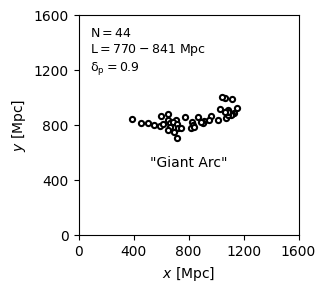

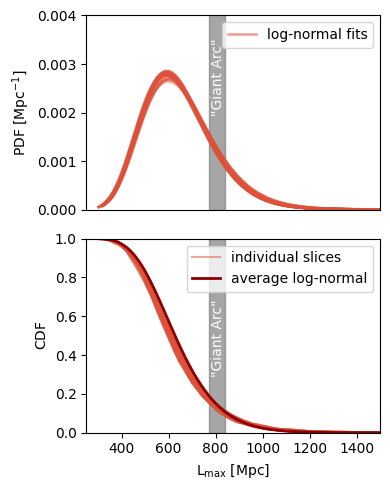

count flam: 11180
count rand: 11257
min: -0.3138949599837958
flamingo percentiles point density: [0.28211538 0.54163859 0.84882023]
random percentiles: [0.26820677 0.52502791 0.81612355]
percentile of 0.9 flamingo: 87.27191413237925
percentile of 0.9 random: 89.34884960469043
flamingo percentile matter density: [-0.00834775  0.01574497  0.04130016]
N_per_slice_rand_mean 0.2765714285714286
N_per_slice_rand_mean 0.27034285714285716
done


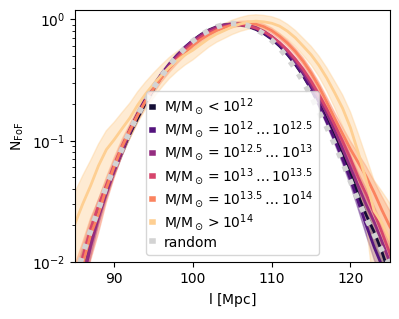

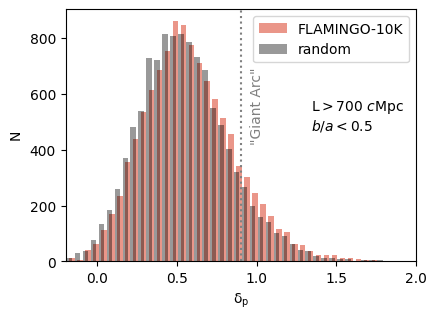

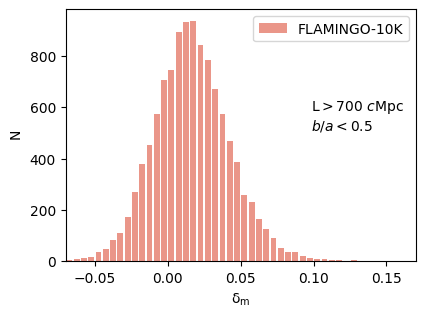

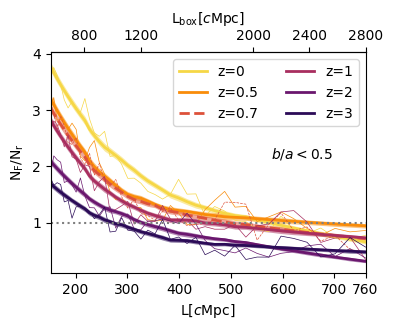

In [23]:
# Find and plot prominent groups (Figure 1). This requires the raw data.
#plot_slices(background = True)

# Plot the Lopez et al. Giant Arc (Figure 1)
plot_GA()

# Plot the PDF and the CDF for the length of the longest structure in 
# random samples of different slices (Figure 2)
plot_len_pdf_cdf()

# Plot the number of groups as a function of linking length and mass (Figure 3)
plot_LL_flamingo_mass()

# Plot histograms of the overdensities (Figure 4)
plot_overdensity_histograms(N=2000, L_min=700)

# Plot the excess of groups as a function of scale and time (Figure 5)
plot_scales_redshifts()


# Main Computing.
### This requires the raw data.

In [24]:
# Compute the PDF for the length of the largest group per slice.
#compute_len_histogram()

# Compute the overdensities (points and particles) of groups in Flamingo
#compute_overdensities_flamingo(N=2000, L_min=700)

# Compute the overdensities (points) of random groups
#compute_overdensities_random(N=2000, L_min=700)

# Compute the number of groups as a function of the linking length
#compute_LL_random()
#compute_LL_flamingo_mass()

# Compute the number of groups as a function of scale and redshift
#compute_scales_redshifts_flamingo()
#compute_scales_redshifts_random()